In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np
import pandas as pd
from scipy import stats, io
import warnings
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.append(os.path.dirname(os.getcwd())) # add parent folder to path
from flow import Paths, design, noise
from stats import rsa, test
from figures import voiplots


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
Folder, _, _, Subjects = Paths.ExpData(fig_subfolder = 'rfx')
ext = '.pdf'
tables_folder = os.environ.get('HOME') + '/_pubs/seq_plos_cb/tables'

### Model evidence: seq model x learning model x task phase

In [10]:
RoiLabels = pd.read_csv(os.path.join(Folder['SourceData'], 'vois_aparc_2009_labels.tsv'), index_col=0)

Models = ['IM', 'N2', 'H']
Phases = ['P','D','R']
Analyses = [[[0], 'SeqId'], [[0,1], 'IsLearned'], [[1], 'SeqId']]

In [11]:
# Y = pd.read_csv('stats.csv', dtype={'IsLearned': str}, index_col=0)
file_stats = os.path.join(Folder['csv'], 'stats.csv')
file_scores = os.path.join(Folder['csv'], 'scores.csv')

if not os.path.exists(file_scores):
    Y, B = rsa.get_scores(Models, Phases, Analyses)
else:
    Y = pd.read_csv(file_stats, dtype={'IsLearned': str}, index_col=0)
    B = pd.read_csv(file_scores, dtype={'IsLearned': str}, index_col=0)

### Test for significance

In [12]:
th = 5 * 10**-3 / (len(Phases) * len(Models)) # bonferroni for phases x models
print('Lower bound significance alpha: ' + str(th))

S = []

for model in ['IM', 'N2', 'H']: # seq rep models
    
    for p in ['D', 'R', 'P']: # task phases
        
        main_filter = (Y.Phase == p) & (Y.Model == model)
        noise_lower_bound_filter = Y.LB_p < th # lower noise bound has to be sig > 0
        item_mixture_null_filter = ((Y.IM + (Y.IM_e * 1)) < Y.LB) # item mixture null-model cannot be > lower noise bound
        model_filter = (Y.LB < (Y.Score - (Y.Score_e * 1))) # model r sign > than lower noise bound
        # novel/unique sequence rep
        M = Y[main_filter & model_filter & item_mixture_null_filter & noise_lower_bound_filter & 
              (Y.IsLearned == '0')]
        # associative learning
        L = Y[main_filter & (Y.IsLearned == '01') & (Y.Voi.isin(M.Voi.values))]
        # chunk learning
        C = Y[main_filter & (Y.IsLearned == '1') & (Y.Voi.isin(M.Voi.values))]
        N = pd.concat([M, L, C], ignore_index=False)
        N = N.drop(['IM', 'IM_e', 'IM_t', 'IM_p', 'LB_p'], axis = 1) 
        S.append(pd.DataFrame(data=N))

S = pd.concat(S, ignore_index=False)

Lower bound significance alpha: 0.0005555555555555556


## Novel sequence representation

In [13]:
s_filter = (S.IsLearned == '0') & (S.Model == model)
print(S[s_filter].shape)
S[s_filter].sort_values(['Lobe', 'Name'])

(13, 13)


Hemi       Lobe                               Name  Voi IsLearned Phase  \
1469     1    Frontal                          Central S  119         0     D   
1431     1    Frontal                    Paracentral G S   81         0     D   
2706     0    Frontal                    Paracentral G S    6         0     R   
2786     1  Occipital                           Cuneus G   86         0     R   
2797     1  Occipital               Occipital Superior G   97         0     R   
2759     0  Occipital   Occipital Superior Transversal S   59         0     R   
25       0   Parietal  Parietal Inferior-Supramarginal G   25         0     P   
1376     0   Parietal                Parietal Superior G   26         0     D   
102      1   Parietal                      Postcentral G  102         0     P   
2841     1   Parietal                      Postcentral S  141         0     R   
141      1   Parietal                      Postcentral S  141         0     P   
2804     1   Parietal                        Precuneus G  104         0     R   
1497     1   Temporal                Temporal Superior S  147         0     D   

     Model        UB        LB     Score   Score_e    Score_t  Score_p  
1469     H  0.295617  0.144616  0.183779  0.023260   7.781652      0.0  
1431     H  0.286477  0.139635  0.171269  0.019923   8.472589      0.0  
2706     H  0.332175  0.204270  0.255825  0.024450   9.770309      0.0  
2786     H  0.315567  0.160370  0.234016  0.018519  11.887350      0.0  
2797     H  0.315077  0.172393  0.214339  0.019327  10.360073      0.0  
2759     H  0.352259  0.239535  0.266892  0.025855   9.725927      0.0  
25       H  0.289965  0.128835  0.148420  0.015098   9.393009      0.0  
1376     H  0.284880  0.118642  0.158523  0.015730   9.412025      0.0  
102      H  0.306211  0.163599  0.186835  0.019473   8.897496      0.0  
2841     H  0.336869  0.197202  0.243513  0.023484  10.098490      0.0  
141      H  0.309384  0.160136  0.194581  0.020938   8.772310      0.0  
2804     H  0.352108  0.242307  0.268992  0.022887  11.338885      0.0  
1497     H  0.303108  0.156616  0.172198  0.015376  10.730739      0.0

In [14]:
S_v = S[s_filter].groupby('Name')['Voi'].apply(lambda group_series: group_series.tolist()).reset_index()
S_p = S[s_filter].groupby('Name')['Phase'].apply(lambda group_series: group_series.tolist()).reset_index()
S_ = pd.DataFrame({'Name': S_p.Name, 'Voi': S_v.Voi, 'Phase': S_p.Phase})
S_

Name         Voi   Phase
0                           Central S       [119]     [D]
1                            Cuneus G        [86]     [R]
2                Occipital Superior G        [97]     [R]
3    Occipital Superior Transversal S        [59]     [R]
4                     Paracentral G S     [81, 6]  [D, R]
5   Parietal Inferior-Supramarginal G        [25]     [P]
6                 Parietal Superior G        [26]     [D]
7                       Postcentral G       [102]     [P]
8                       Postcentral S  [141, 141]  [R, P]
9                         Precuneus G       [104]     [R]
10                Temporal Superior S       [147]     [D]

### Latex table for the manuscript

In [15]:
T = []
for i,j in S_.iterrows():
    v = j.Voi[0]
    row = pd.DataFrame({'Name': RoiLabels['Name'][v], 'Lobe': RoiLabels['Lobe'][v], 'Presentation': np.isin('P', j.Phase),
           'Delay': np.isin('D', j.Phase), 'Response': np.isin('R', j.Phase)}, index = [i])
    T.append(row)
T = pd.concat(T, ignore_index=False)
T.sort_values(['Lobe', 'Name'])

T = T.replace(to_replace = True, value ='\\as') 
T = T.replace(to_replace = False, value ='') 

file_latex = os.path.join(tables_folder,'novel_.tex')
# with open(file_latex,'w') as tf:
#     tf.write(T.to_latex(index=False, bold_rows=True, escape=False, column_format='ll|r|r|r'))
T

Name       Lobe Presentation Delay Response
0                           Central S    Frontal                \as         
1                            Cuneus G  Occipital                         \as
2                Occipital Superior G  Occipital                         \as
3    Occipital Superior Transversal S  Occipital                         \as
4                     Paracentral G S    Frontal                \as      \as
5   Parietal Inferior-Supramarginal G   Parietal          \as               
6                 Parietal Superior G   Parietal                \as         
7                       Postcentral G   Parietal          \as               
8                       Postcentral S   Parietal          \as            \as
9                         Precuneus G   Parietal                         \as
10                Temporal Superior S   Temporal                \as

## Associative learning evidence

In [16]:
bonf = 10**-2 / len(S) # bonferroni threshold for assoc learning
bonferroni_th = (S.Score_p < (bonf))
recode_filter = (S.IsLearned == '01') # chunk sig
L_ = S[recode_filter & bonferroni_th & (S.Model==model) & (S.Phase==p)]
print(L_.Voi.values)
print(str(L_.Voi.values.shape[0]) + ' significant regions')

[]
0 significant regions


## Recoding / chunk evidence

In [17]:
bonf = 10**-2 / len(C) # bonferroni threshold for recoding evidence
bonferroni_th = (S.Score_p < (bonf))
recode_filter = (S.IsLearned == '1') # chunk sig
C_ = S[recode_filter & bonferroni_th & (S.Model==model) & (S.Phase==p)]
print(C_.Voi.values)
print(str(C_.Voi.values.shape[0]) + ' significant regions')

[ 25 102 141]
3 significant regions


### Plots

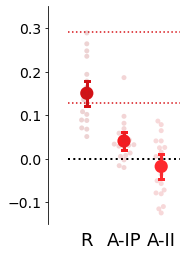

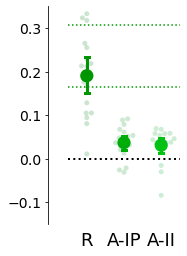

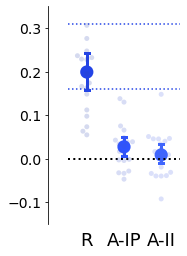

In [18]:
for i,v in enumerate(C_.Voi.values):
    
    B_ = B[(B.IsLearned!='1') & (B.Voi == v) & (B.Phase==p)]
    B_.R = np.arctanh(B_.R)
    B_ = B_[((B_.IsLearned!='1') & (B_.Model=='H')) | ((B_.IsLearned=='01') & (B_.Model.isin(['N2'])))]
    
    # rename model labels to fit with manuscript abbreviations
    B_['Model'].loc[B_.loc[(B_.IsLearned=='0') & (B_.Model=='H')].index] = 'R'
    B_['Model'].loc[B_.loc[B_.Model=='H'].index] = 'A-IP'
    B_['Model'].loc[B_.loc[B_.Model=='N2'].index] = 'A-II'
    
    # plot
    fig = plt.figure(figsize=(2,4))
    ax = voiplots.model(i, x='Model', y='R', data=B_)
    #fig.savefig(os.path.join(Folder['Fig'], str(v) + ext), bbox_inches = "tight")

### Plots for novel seq rep

In [19]:
S_

Name         Voi   Phase
0                           Central S       [119]     [D]
1                            Cuneus G        [86]     [R]
2                Occipital Superior G        [97]     [R]
3    Occipital Superior Transversal S        [59]     [R]
4                     Paracentral G S     [81, 6]  [D, R]
5   Parietal Inferior-Supramarginal G        [25]     [P]
6                 Parietal Superior G        [26]     [D]
7                       Postcentral G       [102]     [P]
8                       Postcentral S  [141, 141]  [R, P]
9                         Precuneus G       [104]     [R]
10                Temporal Superior S       [147]     [D]

In [20]:
S_.Name = S_.Name.str.replace('Occipital', 'Occ')
S_.Name = S_.Name.str.replace('Parietal', 'Par')
S_.Name = S_.Name.str.replace('Superior', 'Sup')
S_.Name = S_.Name.str.replace('Transversal', 'Tv')
S_.Name = S_.Name.str.replace('Inferior-Supramarginal', 'Inf-SM')

S_

Name         Voi   Phase
0         Central S       [119]     [D]
1          Cuneus G        [86]     [R]
2         Occ Sup G        [97]     [R]
3      Occ Sup Tv S        [59]     [R]
4   Paracentral G S     [81, 6]  [D, R]
5      Par Inf-SM G        [25]     [P]
6         Par Sup G        [26]     [D]
7     Postcentral G       [102]     [P]
8     Postcentral S  [141, 141]  [R, P]
9       Precuneus G       [104]     [R]
10   Temporal Sup S       [147]     [D]

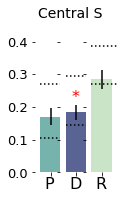

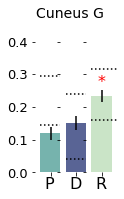

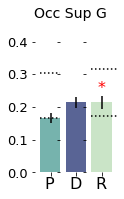

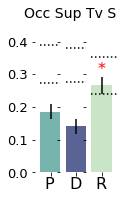

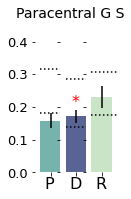

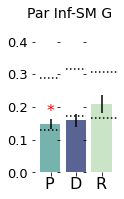

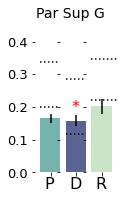

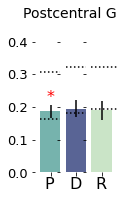

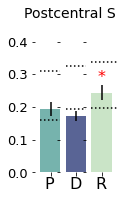

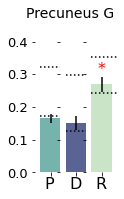

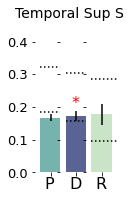

In [22]:
%autoreload voiplots

def sem(x):
    return np.nanstd(x) / np.sqrt(x.shape[0] - 1) # SEM

for i,j in S_.iterrows():
    v = j.Voi[0]
    b_ = B[(B.IsLearned=='0') & (B.Model==model) & (B.Voi.isin([v]))]
    bg = pd.concat([b_.groupby(['Phase']).mean(), b_.groupby(['Phase']).R.agg([sem])], axis=1).reset_index()
    bg = bg.reindex([1, 0, 2])
    bg['sig'] = [j.Phase] * 3
    bg['Name'] = j.Name
    g = voiplots.noise_phase(bg)
    file_n = os.path.join(Folder['Fig'], 'n-' + str(i) + '-' + str(v) + ext)
    #g.savefig(file_n, bbox_inches = "tight")